In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

sys.path.insert(0, '../kinetic_analysis')
from kinetic_function import (single_track_analysis,
                              generate_track
                             )

In [2]:
prot_aa_size = {
    "32xsuntag": 796,  #768/32=24 , left 28
    "linker": 4,
    "twist": 490,
    "ilp4": 134,
    "snail": 390,
    "very_long_prot":2000, 
}

In [3]:
path_save = "/home/u2175049/Documents/Code/KineticAnalysis/notebook/figures/"
path = "/mnt/sda1/Sophie/2-KineticAnalysisData/2-Datas/05-Modelling/08_InitiationRate/"

In [9]:
first_time = True
for rt in [1, 5, 10, 15, 20, 30, 50, 75, 100]:
    for i in range(100):
        x_global, y_global, y_start_prot = generate_track(prot_length = prot_aa_size["snail"], 
                                                          suntag_length = prot_aa_size["32xsuntag"],
                                                          nb_suntag=32, 
                                                          fluo_one_suntag=4, 
                                                          translation_rate=24, 
                                                          binding_rate=1/rt,
                                                          retention_time=0,
                                                          suntag_pos="begin",
                                                          step = 0.1,
                                                          length=6000)
        if first_time:
            datas = pd.DataFrame({"FRAME":x_global,
                                  "MEAN_INTENSITY_CH1":y_global,
                                  "TRACK_ID" : i,
                                  "INITIATION_RATE":rt,
                                 })
            first_time = False
        else:
            datas = pd.concat([datas, 
                               pd.DataFrame({"FRAME":x_global,
                                              "MEAN_INTENSITY_CH1":y_global,
                                              "TRACK_ID" : i,
                                             "INITIATION_RATE":rt,
                                 })], ignore_index=True)


datas.to_csv(os.path.join(path, "datas_initiation_rate.csv"))

In [4]:
datas = pd.read_csv(os.path.join(path, "datas_initiation_rate.csv"), index_col="Unnamed: 0")

In [33]:
first_time = True
dt = 3
t = dt/0.1
for rt in [1, 5, 10, 15, 20, 30, 50, 75, 100]:
    prot_length = prot_aa_size["32xsuntag"]+prot_aa_size["snail"]
    for i in range(100):
        datas2 =datas[(datas["TRACK_ID"]==i) & (datas["INITIATION_RATE"]==rt)][::int(t)]
        (x, 
        y, 
        x_auto, 
        y_auto, 
        elongation_r, 
        translation_init_r,
        perr) = single_track_analysis(datas2,
                                     i, 
                                     delta_t = dt,
                                     protein_size=prot_length,
                                     normalise_intensity=1,
                                     normalise_auto=True,
                                     mm=None,
                                     lowpass_=False,
                                     cutoff=100,
                                     rtol=1e-1,
                                     method="linear",
                                     force_analysis=True,
                                     first_dot=True,
                                     simulation=True)
        if first_time:
            results = pd.DataFrame({"elongation_r":elongation_r, 
                                    "init_translation_r":translation_init_r, 
                                    "dt":dt,
                                   "id":i,
                                   "initiation_rate":rt},
                                  index=[0])
            first_time = False
        
        else:
            results = pd.concat([results, 
                            pd.DataFrame({"elongation_r":elongation_r, 
                                          "init_translation_r":translation_init_r, 
                                          "dt":dt, 
                                          "id":i,
                                         "initiation_rate":rt}, index=[0])
                            ], ignore_index=True)
results.to_csv(os.path.join(path, "results_initiation_rate.csv"))

In [6]:
results.groupby(by='initiation_rate')[['elongation_r','init_translation_r']].mean()

,elongation_r,init_translation_r
initiation_rate,,
1,20.872256,1.221399
5,21.851486,6.472469
10,21.785783,13.255290
15,20.929996,20.446803
20,20.682037,27.920657
30,20.591325,41.458230
50,20.952908,66.921892
75,20.817299,104.498435
100,21.577235,136.316944


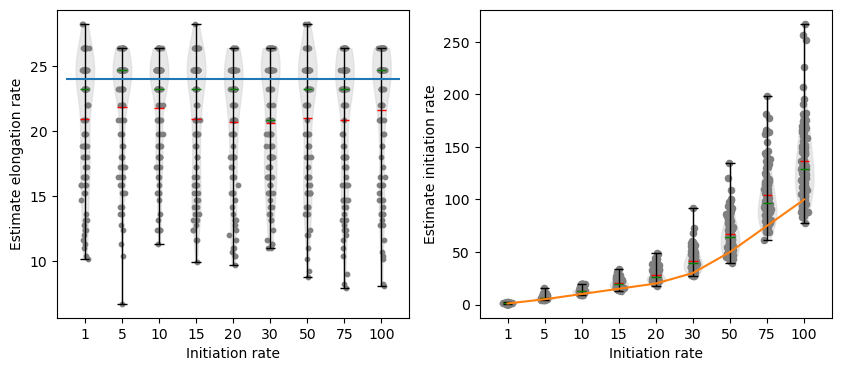

In [26]:
fig, ax = plt.subplots(1,2)

violin = ax[0].violinplot(dataset = [results[results.initiation_rate == i]["elongation_r"].values 
                                     for i in [1, 5, 10, 15, 20, 30, 50, 75, 100]
                          ],showmeans=True,
      showmedians=True)

for pc in violin["bodies"]:
    pc.set_facecolor("lightgrey")
    pc.set_edgecolor("lightgrey")
    pc.set_alpha(0.5)

colors = ["black", "black", "black", "red", "green"]
i=0
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin[partname]
    vp.set_edgecolor(colors[i])
    vp.set_linewidth(1)
    i+=1
    

violin = ax[1].violinplot(dataset = [results[results.initiation_rate == i]["init_translation_r"].values 
                                     for i in [1, 5, 10, 15, 20, 30, 50, 75, 100]
                                    ], showmeans=True,
      showmedians=True)


for pc in violin["bodies"]:
    pc.set_facecolor("lightgrey")
    pc.set_edgecolor("lightgrey")
    pc.set_alpha(0.5)

colors = ["black", "black", "black", "red", "green"]
i=0
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin[partname]
    vp.set_edgecolor(colors[i])
    vp.set_linewidth(1)
    i+=1
    
group = 'initiation_rate'
column = 'elongation_r'
grouped = results.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[0].scatter(x, val, c='grey', alpha=1, s=10)
    
group = 'initiation_rate'
column = 'init_translation_r'
grouped = results.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[1].scatter(x, val, c='grey', alpha=1, s=20)

    
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Initiation rate')
# set style for the axes
labels = [1, 5, 10, 15, 20, 30, 50, 75, 100]
for a in ax:
    set_axis_style(a, labels)

ax[0].set_ylabel("Estimate elongation rate")
ax[1].set_ylabel("Estimate initiation rate")
    
# ax[1].set_ylim(0,250)
ax[0].hlines(24, 0.5, 9.5)
ax[1].plot([1,2,3,4,5,6,7,8,9], [1, 5, 10, 15, 20, 30, 50, 75, 100])
fig.set_size_inches((10,4))
# fig.savefig(os.path.join(path_save, "results_retention_time_boxplot_original.eps"), dpi=300)

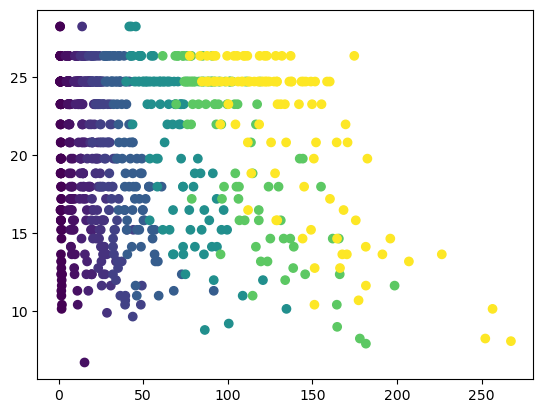

In [27]:
fig, ax = plt.subplots()
ax.scatter(results["init_translation_r"], results["elongation_r"], c=results["initiation_rate"])

In [19]:
results[abs(results["elongation_r"]-24.708333) <=0.1]

,elongation_r,init_translation_r,dt,id,initiation_rate
1,24.708333,1.096236,3,1,1
2,24.708333,0.934174,3,2,1
3,24.708333,0.981501,3,3,1
5,24.708333,0.983872,3,5,1
11,24.708333,0.955997,3,11,1
...,...,...,...,...,...
884,24.708333,136.327003,3,84,100
889,24.708333,160.191688,3,89,100
893,24.708333,120.858334,3,93,100
894,24.708333,99.264352,3,94,100


In [28]:
from scipy.stats import bootstrap

d = (results[results.initiation_rate == 20]["init_translation_r"].to_numpy(),)
bootstrap_ci = bootstrap(d,
                          np.mean, 
                          confidence_level=0.95,
                          method="percentile"
                         )
bootstrap_ci.confidence_interval

ConfidenceInterval(low=26.68702930823862, high=29.212682009323668)

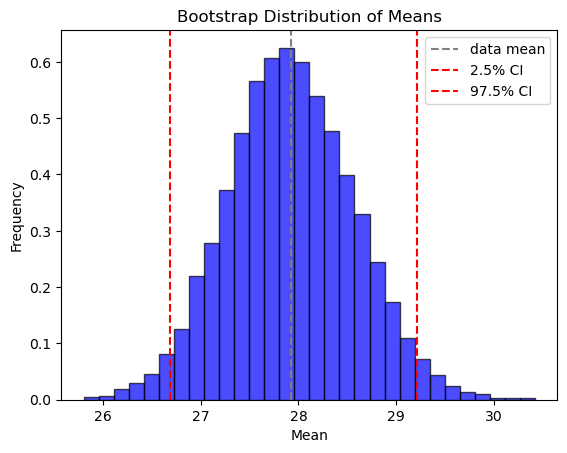

ConfidenceInterval(low=26.68702930823862, high=29.212682009323668)
Bootstrap Mean Estimate: 	27.92320395596491
Bootstrap Median Estimate: 	27.911717873476174
Bootstrap Standard Error: 	0.6440083841575314
Mean: 	27.92065698547034
Bootstrap Bias: 0.002546970494570644


In [29]:
import matplotlib.pyplot as plt

plt.hist(bootstrap_ci.bootstrap_distribution, density=True, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Bootstrap Distribution of Means')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.axvline(np.mean(d)  , color='grey', linestyle='dashed', label='data mean')
plt.axvline(bootstrap_ci.confidence_interval.low, color='red', linestyle='dashed', label='2.5% CI')
plt.axvline(bootstrap_ci.confidence_interval.high, color='red', linestyle='dashed', label='97.5% CI')
plt.legend()
plt.show()

print(bootstrap_ci.confidence_interval)
# calculate central tendency
mean_estimate = np.mean(bootstrap_ci.bootstrap_distribution)
median_estimate = np.median(bootstrap_ci.bootstrap_distribution)
print(f"Bootstrap Mean Estimate: \t{mean_estimate}")
print(f"Bootstrap Median Estimate: \t{median_estimate}")

# measure variability
standard_error = np.std(bootstrap_ci.bootstrap_distribution)
print(f"Bootstrap Standard Error: \t{standard_error}")

# Assess bias
original_statistic = np.mean(d)  
print(f"Mean: \t{original_statistic}")
bias = np.mean(bootstrap_ci.bootstrap_distribution) - original_statistic
print(f"Bootstrap Bias: {bias}")



In [31]:
result_group = results.groupby(by='initiation_rate')[['elongation_r','init_translation_r']].mean()
result_group

,elongation_r,init_translation_r
initiation_rate,,
1,20.872256,1.221399
5,21.851486,6.472469
10,21.785783,13.255290
15,20.929996,20.446803
20,20.682037,27.920657
30,20.591325,41.458230
50,20.952908,66.921892
75,20.817299,104.498435
100,21.577235,136.316944


In [32]:
result_group["ratio"] = 100*result_group["init_translation_r"]/result_group.index
result_group

,elongation_r,init_translation_r,ratio
initiation_rate,,,
1,20.872256,1.221399,122.139861
5,21.851486,6.472469,129.449390
10,21.785783,13.255290,132.552901
15,20.929996,20.446803,136.312021
20,20.682037,27.920657,139.603285
30,20.591325,41.458230,138.194099
50,20.952908,66.921892,133.843785
75,20.817299,104.498435,139.331247
100,21.577235,136.316944,136.316944
